PCA

conda create -n pca --> 
conda activate pca

In [1371]:
#epsilon for differential privacy
epsilon=0

#desired_variance = 1 - maximum information loss 
desired_variance = 0.99
#KNN number of neighbors
k=50

#KNN distance metric ['euc', 'sqd', 'max', 'cab']
distance_metric = 'euc'

In [1372]:
# Temporary fix to kernel not responding
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Import necessary libraries
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1373]:
def perform_svd(data):
    # Convert the data into a PyTorch tensor
    tensor_data = torch.Tensor(data.values)

    # Compute the SVD where S is the eigenvalues and V is the eigenvectors
    U, S, V = torch.linalg.svd(tensor_data)

    return U, S, V, tensor_data

def display_shape(S, V):
    print("Shape of eigenvalues (S):", S.shape)
    print("Shape of eigenvectors (V):", V.shape)

Perform PCA to the data you choose!

In [1374]:
file_path_t = f'../epsilon{epsilon}/test.data'
file_path_v = f'../epsilon{epsilon}/val.data'
file_path_s = f'../epsilon{epsilon}/gene.data'

In [1375]:
from torch.utils.data import Dataset

# Define a custom dataset class
class TrajectoryDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Load the real data
data_test = pd.read_csv(file_path_t, sep=" ", header=None)
data_test = torch.unique(torch.Tensor(data_test.values), dim=0)
data_test = pd.DataFrame(data_test)
labels_test = torch.ones(len(data_test))  # Label real data with 1

data_validation = pd.read_csv(file_path_v, sep=" ", header=None)
data_validation = torch.unique(torch.Tensor(data_validation.values), dim=0)
data_validation = pd.DataFrame(data_validation)
labels_validation = torch.ones(len(data_validation))  # Label real data with 1

# Load the synthetic data
data_synthetic = pd.read_csv(file_path_s, sep=" ", header=None)
data_synthetic = torch.unique(torch.Tensor(data_synthetic.values), dim=0)
data_synthetic = pd.DataFrame(data_synthetic)
labels_s = torch.zeros(len(data_synthetic))  # Label synthetic data with 0

# Create datasets
dataset_original_real = TrajectoryDataset(pd.concat([data_test, data_validation]).values, torch.cat([labels_test, labels_validation]))
dataset_original_synthetic = TrajectoryDataset(data_synthetic.values, labels_s)

print("Real data shape:", dataset_original_real.data.shape)
print("Synthetic data shape:", dataset_original_synthetic.data.shape)

Real data shape: (3380, 48)
Synthetic data shape: (8765, 48)


In [1376]:
# Perform SVD on the converted DataFrame
U_real, S_real, V_real, real_data_tensor = perform_svd(pd.DataFrame(dataset_original_real.data))

display_shape(S_real, V_real)

Shape of eigenvalues (S): torch.Size([48])
Shape of eigenvectors (V): torch.Size([48, 48])


In [1377]:
# Perform SVD on the converted DataFrame
U_synthetic, S_synthetic, V_synthetic, synthetic_data_tensor = perform_svd(pd.DataFrame(dataset_original_synthetic.data))

display_shape(S_synthetic, V_synthetic)

Shape of eigenvalues (S): torch.Size([48])
Shape of eigenvectors (V): torch.Size([48, 48])


Covariance matrix

In [1378]:
def calculate_covariance_matrix(V, S):
    # Calculate the covariance matrix
    cov_matrix = torch.mm(torch.mm(V, torch.diag(S)), V.t())

    # Print the covariance matrix
    #print('Covariance Matrix:')
    #print(cov_matrix)
    #print('cov_matrix = ',cov_matrix.shape)

calculate_covariance_matrix(V_real, S_real)

calculate_covariance_matrix(V_synthetic, S_synthetic)

Variance of the components

In [1379]:
def calculate_cumulative_variance(S):
    # Calculate the variance explained by each principal component
    variance_per_pc = (S ** 2) / torch.sum(S ** 2)

    # Calculate the cumulative variance explained
    cumulative_variance = torch.cumsum(variance_per_pc, dim=0)

    return cumulative_variance

In [1380]:
cumulative_variance_real = calculate_cumulative_variance(S_real)
cumulative_variance_synthetic = calculate_cumulative_variance(S_synthetic)

In [1381]:
def scree_graph(cumulative_variance_real, cumulative_variance_synthetic):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance_real) + 1), cumulative_variance_real, linestyle='-', marker='x', color='red', label='Real Data')
    plt.plot(range(1, len(cumulative_variance_synthetic) + 1), cumulative_variance_synthetic, linestyle='-', marker='x', color='blue', label='Synthetic Data')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance')
    plt.legend()
    plt.title('Scree Graph')
    plt.show()

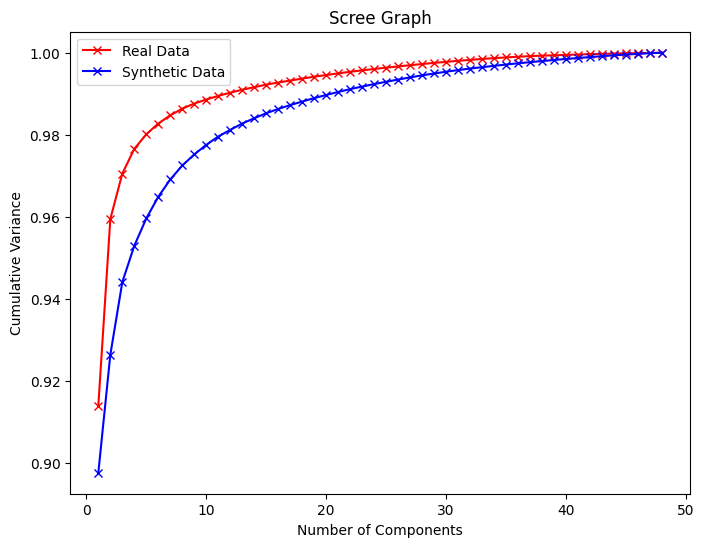

In [1382]:
scree_graph(cumulative_variance_real, cumulative_variance_synthetic)

In [1383]:
def get_num_components(cumulative_variance, desired_variance):
    num_components = torch.sum(cumulative_variance < desired_variance)
    if num_components.item() == 0:
        num_components = torch.tensor(1)
    return num_components.item()

num_components_needed = get_num_components(cumulative_variance_synthetic, desired_variance)
print("Number of principal components needed for a cumulative variance explained of", desired_variance, ":", num_components_needed, " components")

Number of principal components needed for a cumulative variance explained of 0.99 : 20  components


In [1384]:
# Project the real_data onto the plane formed by the principal components
dataset_nr = TrajectoryDataset(torch.matmul(real_data_tensor,V_synthetic[:, :num_components_needed]), torch.ones(len(dataset_original_real.data)))

# Project the real_data onto the plane formed by the principal components
dataset_ns = TrajectoryDataset(torch.matmul(synthetic_data_tensor,V_synthetic[:, :num_components_needed]), torch.ones(len(dataset_original_synthetic.data)))

print("Real data shape:", dataset_nr.data.shape)
print("Synthetic data shape:", dataset_ns.data.shape)

Real data shape: torch.Size([3380, 20])
Synthetic data shape: torch.Size([8765, 20])


In [1385]:
# Plotting the real and synthetic new coordinates
def new_coordinates_comparison(new_coordinates_real, new_coordinates_synthetic, num_components_needed):
    if(num_components_needed < 2):
        return
    else:
        plt.figure(figsize=(8, 6))
        plt.scatter(new_coordinates_real[:, 0], new_coordinates_real[:, 1], label='Real', s=1)
        plt.scatter(new_coordinates_synthetic[:, 0], new_coordinates_synthetic[:, 1], label='Synthetic', s=1)
        plt.xlabel('First Principal Component')
        plt.ylabel('Second Principal Component')
        plt.title('New Coordinates on First and Second Principal Components')
        plt.legend()
        plt.show()

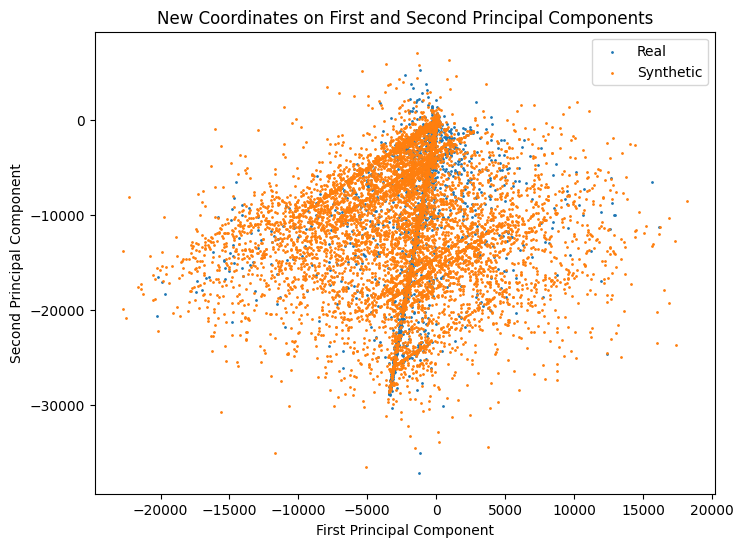

In [1386]:
new_coordinates_comparison(dataset_nr.data, dataset_ns.data, num_components_needed)

KNN

In [1387]:
class KNN():
    def __init__(self, distance:str = 'max') -> None:
        self.constellation = None
        self.dim = None
        self.available_dist = ['euc', 'sqd', 'max', 'cab']
        self.ensure_distance(distance)
        self.distance = distance
    
    def fit(self, constellation:torch.Tensor)-> None:
        self.constellation = constellation
        self.dim = len(self.constellation.shape)-1
    
    def set_distance(self, distance: str)-> None:
        self.ensure_distance(distance)
        self.distance = distance
    
    def ensure_distance(self, distance):
        if distance not in self.available_dist:
            raise NotAvailableFeature(f'Feature not available {distance}, currently only available distances: {self.available_dist}')
    
    def compute_distance(self, X:torch.Tensor)-> torch.Tensor:
        '''
        Computing distances from X to each point in the constellation depending on the self.distance value the metric will differ:
            - euc: Euclidean distance between points
            - sqd: Squared euclidean distance
            - max: Tchebychev distance (maximum metric)
            - cab: Taxicab distance or Manhattan distance
        '''
        if self.distance == self.available_dist[0]:
            dist = self.constellation.add( - X).pow(2).sum(dim=self.dim).pow(.5) 
        elif self.distance == self.available_dist[1]:
            dist = self.constellation.add( - X).pow(2).sum(dim=self.dim)
        elif self.distance == self.available_dist[2]:
            dist = torch.abs(self.constellation.add( - X)).max(dim=self.dim).values
        elif self.distance == self.available_dist[3]:
            dist = torch.abs(self.constellation.add( - X)).sum(dim=self.dim)
        return dist
    
    def kneighbours(self, X:torch.Tensor, k:int=4)-> tuple:
        '''
        Inputs:
        # X: A single trajectory that we want to check if it is similar to the original data.
        # k: the number of k nearest neighbours we want to see in the output
        Outputs:
        # dist: Distances to the first k-nearest neighbours
        # knn_indices: Indexes of the k-nearest neighbours
        '''
        if self.dim != None and self.dim>0:
            X = X.expand(self.constellation.shape) # Repeat the same two point traj N times until shape matches with the synthetic trajectories

            # Computing distance
            dist = self.compute_distance(X)
            # Getting the k nearest points
            knn_indices = dist.topk(k, largest=False, sorted=False)[1] # Getting the k smallest distances

            return dist[knn_indices], knn_indices
        else:
            raise ModelNotFit('The model has not been fit with the constellation or the constellation is empty. Before using model.kneighbours use model.fit with a propper constellation')

class ModelNotFit(Exception):
    def __init__(self, *args: object) -> None:
        super().__init__(*args)

class NotAvailableFeature(Exception):
    def __init__(self, *args: object) -> None:
        super().__init__(*args)

In [1388]:
#We split the dataset to perform unupervised learning
from torch.utils.data import random_split
import math

dataset_ns_split1, dataset_ns_split2=random_split(dataset_ns.data, [math.ceil(0.5*len(dataset_ns.data)), math.floor(0.5*len(dataset_ns.data))])
loader = torch.utils.data.DataLoader(dataset_ns_split1, batch_size=4,shuffle=True, num_workers=2)

In [1389]:
# Create an instance of the KNN class
knn = KNN(distance_metric)

# Fit the KNN model with the synthetic data
knn.fit(dataset_ns_split1.dataset[dataset_ns_split1.indices])

knn_training_dataset=TrajectoryDataset(torch.cat([dataset_ns_split2.dataset[dataset_ns_split2.indices], dataset_nr.data]), torch.cat([torch.ones(len(dataset_ns_split2)), torch.zeros(len(dataset_nr.data))]))

distances=torch.LongTensor([])
indices=torch.IntTensor([])
labels=torch.IntTensor([])

for i, (trajectory, label) in enumerate(knn_training_dataset):
    knn_distances, knn_indices = knn.kneighbours(trajectory[0], k)
    knn_distances=knn_distances.unsqueeze(0)
    knn_indices=knn_indices.unsqueeze(0)
    knn_labels=label.unsqueeze(0)

    distances=torch.cat([distances, knn_distances],0)
    indices=torch.cat([indices, knn_indices],0)
    labels=torch.cat([labels, knn_labels],0)


SVM

In [1390]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(distances.numpy(), labels.numpy(), test_size=0.3,random_state=109) # 70% training and 30% test

#Import svm model
from sklearn import svm
from sklearn import metrics

In [1391]:
#Linear SVM Classifier
#linearSVMClassifier = svm.SVC(kernel='linear', probability=True) # Linear Kernel

#Train the model using the training sets
#linearSVMClassifier.fit(X_train, y_train)

#Predict the response for test dataset
#linear_y_pred = linearSVMClassifier.predict(X_test)

In [1392]:
#Poly SVM Classifier
#polySVMClassifier = svm.SVC(kernel='poly', degree=4, probability=True) # Poly Kernel

#Train the model using the training sets
#polySVMClassifier.fit(X_train, y_train)

#Predict the response for test dataset
#poly_y_pred = polySVMClassifier.predict(X_test)

In [1393]:
#RBF SVM Classifier
rbfSVMClassifier = svm.SVC(kernel='rbf', probability=True) # RBF Kernel

#Train the model using the training sets
rbfSVMClassifier.fit(X_train, y_train)

#Predict the response for test dataset
rbf_y_pred = rbfSVMClassifier.predict(X_test)

In [1394]:
#Import svm model
from sklearn.ensemble import RandomForestClassifier

#Random Forest Classifier
clf=RandomForestClassifier(n_estimators=100,random_state=0)

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
randomForest_y_pred = clf.predict(X_test)

TESTS

In [1396]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
def mia_test(X_test, y_pred, y_test, classifier, estimator_name):
    
    # Plot the ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    roc_curve_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=estimator_name)
    roc_curve_display.plot()
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.show()

    # Model ROC AUC Score: what percentage of positive tuples are labelled as such?
    print("ROC AUC Score:",metrics.roc_auc_score(y_test, y_pred))

    # Model Accuracy: how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:",metrics.precision_score(y_test, y_pred))

    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Recall:",metrics.recall_score(y_test, y_pred))

    # Model F1 Score: what percentage of positive tuples are labelled as such?
    print("F1 Score:",metrics.f1_score(y_test, y_pred))

    # Model Confusion Matrix
    cm=metrics.confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:",)
    cmd=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['0', '1'])
    cmd.plot()
    plt.savefig(f'confusion_matrix_{estimator_name}.png')
    plt.show()


In [1397]:
#SVC LINEAR
#mia_test(X_test, linear_y_pred, y_test, linearSVMClassifier, 'SVC Linear')

In [1398]:
#SVC POLY
#mia_test(X_test, poly_y_pred, y_test, polySVMClassifier, 'SVC Poly')

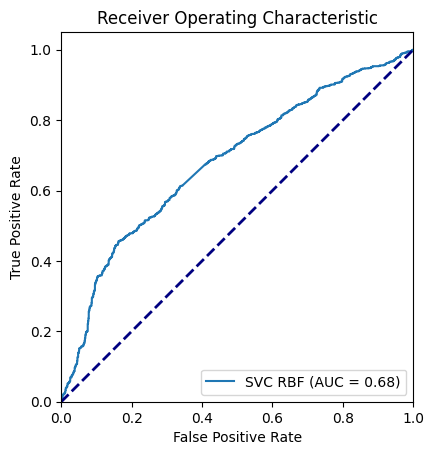

ROC AUC Score: 0.6426058656292085
Accuracy: 0.6212966938600257
Precision: 0.7670886075949367
Recall: 0.4647239263803681
F1 Score: 0.5787965616045845
Confusion Matrix:


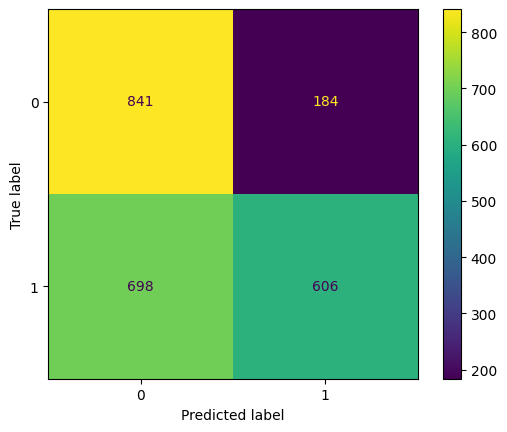

In [1399]:
#SVC RBF
mia_test(X_test, rbf_y_pred, y_test, rbfSVMClassifier, 'SVC RBF')

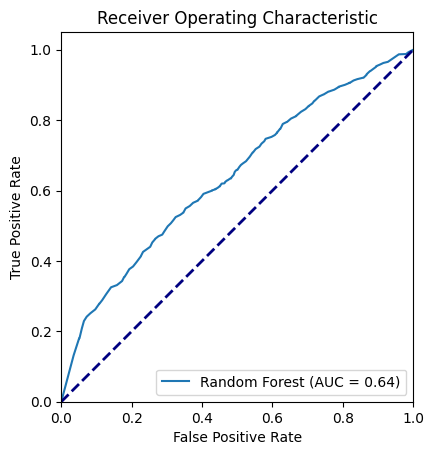

ROC AUC Score: 0.5761256172377675
Accuracy: 0.5830828681837699
Precision: 0.6260408781226343
Recall: 0.63420245398773
F1 Score: 0.630095238095238
Confusion Matrix:


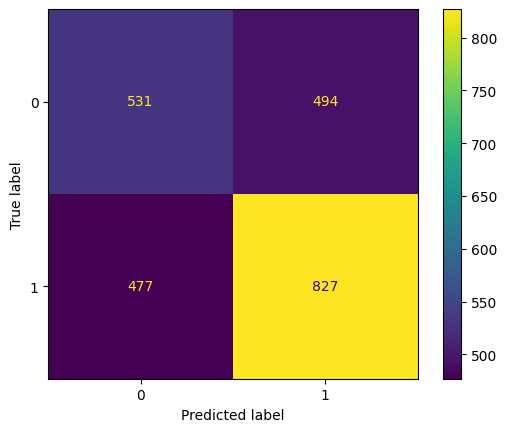

In [1400]:
#Random Forest
mia_test(X_test, randomForest_y_pred, y_test, clf, 'Random Forest')

In [ ]:
# Calculate ROC curve and AUC for SVM-RBF
fpr_rbf, tpr_rbf, thresholds_rbf = metrics.roc_curve(y_test, rbfSVMClassifier.predict_proba(X_test)[:,1])
roc_auc_rbf = metrics.auc(fpr_rbf, tpr_rbf)

# Calculate ROC curve and AUC for Random Forest
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)

# Plotting both ROC curves on the same graph
plt.figure()

# SVM-RBF ROC curve
plt.plot(fpr_rbf, tpr_rbf, color='darkorange', lw=2, label=f'SVM-RBF (AUC = {roc_auc_rbf:.2f})')

# Random Forest ROC curve
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

# Random guessing line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Graph formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC.png')
plt.show()